## How much money can a director lose before they disappear in the industry?

### How many box office bombs can an established director endure?

In [156]:
# 20200726 JLCY
# data from https://www.the-numbers.com/

import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

xl = pd.ExcelFile('directors_data.xlsx')
print('number of directors:', len(xl.sheet_names))

eliminate_yr_threshold = 2016

pd.options.mode.chained_assignment = None

number of directors: 50


In [ ]:
    def assign_profitable_movie_count(df, profit_count, unprofit_count, unknown_count, condition_df=None): 
    
        df[profit_count] = 0
        df[unprofit_count] = 0
        df[unknown_count] = 0

        if math.isnan(df['Profit'].iloc[-1]): 
            df[unknown_count].iloc[-1] += 1
        else: 
            if df['Profit'].iloc[-1] > 0: 
                df[profit_count].iloc[-1] += 1
            else: 
                df[unprofit_count].iloc[-1] += 1
                
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                if math.isnan(df['Profit'][i]): 
                    df[unknown_count][i] = df[unknown_count][i+1:].max() + 1
                else: 
                    if df['Profit'][i] > 0: 
                        df[profit_count][i] = df[profit_count][i+1:].max() + 1
                    else: 
                        df[unprofit_count][i] = df[unprofit_count][i+1:].max() + 1
            else: 
                df[profit_count][i] = df[profit_count][i+1]
                df[unprofit_count][i] = df[unprofit_count][i+1]
                df[unknown_count][i] = df[unknown_count][i+1]

In [ ]:
#         df['Profitable Movie Director Count'] = 0
#         df['Unprofitable Movie Director Count'] = 0
#         df['Unknown profit Movie Director Count'] = 0
        
        if math.isnan(df['Profit'].iloc[-1]): # bottom row
            df['Unknown profit Movie Count'].iloc[-1] += 1
#             if df.iloc[-1]['Role'] == 'Director': 
#                 df['Unknown profit Movie Director Count'].iloc[-1] += 1
        else: 
            if df['Profit'].iloc[-1] > 0: 
                df['Profitable Movie Count'].iloc[-1] += 1
#                 if df.iloc[-1]['Role'] == 'Director': 
#                     df['Profitable Movie Director Count'].iloc[-1] += 1
            else: 
                df['Unprofitable Movie Count'].iloc[-1] += 1
#                 if df.iloc[-1]['Role'] == 'Director': 
#                     df['Unprofitable Movie Director Count'].iloc[-1] += 1
                
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                if math.isnan(df['Profit'][i]): 
                    df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1:].max() + 1
#                     if df['Role'][i] == 'Director': 
#                         df['Unknown profit Movie Director Count'][i] = df['Unknown profit Movie Director Count'][i+1:].max() + 1
                else: 
                    if df['Profit'][i] > 0: 
#                         print(df.iloc[i])
                        df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1:].max() + 1
#                         if df['Role'][i] == 'Director': 
#                             print(df['Profitable Movie Director Count'][i+1:])
#                             df['Profitable Movie Director Count'][i] = df['Profitable Movie Director Count'][i+1:].max() + 1
                    else: 
                        df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1:].max() + 1
#                         if df['Role'][i] == 'Director': 
#                             df['Unprofitable Movie Director Count'][i] = df['Unprofitable Movie Director Count'][i+1:].max() + 1
            else: 
                df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1]
                df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1]
                df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1]

In [305]:
if os.path.exists('single_df.csv'): 
    
    combine_df = pd.read_csv('single_df.csv')
    
else: 
    
#     def assign_profitable_movie_count(df, profit_count, unprofit_count, unknown_count): 
    
#         df[profit_count] = 0
#         df[unprofit_count] = 0
#         df[unknown_count] = 0

#         if math.isnan(df['Profit'].iloc[-1]): 
#             df[unknown_count].iloc[-1] += 1
#         else: 
#             if df['Profit'].iloc[-1] > 0: 
#                 df[profit_count].iloc[-1] += 1
#             else: 
#                 df[unprofit_count].iloc[-1] += 1
                
#         for i in reversed(df.index[:-1]): 
#             if df['Title'][i] != df['Title'][i+1]: 
#                 if math.isnan(df['Profit'][i]): 
#                     df[unknown_count][i] = df[unknown_count][i+1:].max() + 1
#                 else: 
#                     if df['Profit'][i] > 0: 
#                         df[profit_count][i] = df[profit_count][i+1:].max() + 1
#                     else: 
#                         df[unprofit_count][i] = df[unprofit_count][i+1:].max() + 1
#             else: 
#                 df[profit_count][i] = df[profit_count][i+1]
#                 df[unprofit_count][i] = df[unprofit_count][i+1]
#                 df[unknown_count][i] = df[unknown_count][i+1]
    
    append_data = []

    for sheet_name in xl.sheet_names[10:12]: 

        #print(sheet_name)

        xl_file = pd.read_excel('directors_data.xlsx', sheet_name=sheet_name)

        # combine 1st 2 rows as column names
        combine_col = []

        for ind, col in enumerate(xl_file.columns): 

            if isinstance(xl_file.iloc[0, ind], str): 
                combine_col.append(col + ' ' + xl_file.iloc[0, ind])
            else: 
                combine_col.append(col)

        combine_col = ['Opening Theaters' if i == 'Opening.1 Theaters' else i for i in combine_col]

        xl_file.columns = combine_col

        df = xl_file.iloc[1:-3] # drop 1st row and last 3 summary rows
        df.reset_index(inplace=True)
        df = df.iloc[:, 1:] # drop 1st duplicating column

        # populate data for multiple roles in the same movie
        nan_col = [col for col in df.columns if col not in ['Role']]

        for i in df.index: 

            if type(df['Title'][i]) is float: 

                if math.isnan(df['Title'][i]) and isinstance(df['Role'][i], str): 

                    for col in nan_col: 
                        df[col][i] = df[col][i-1] # set data to the row above

        df['Person'] = sheet_name
        
        df['Release Date'] = pd.to_datetime(df['Release Date'])

        if df['Release Date'].dt.year.unique().max() < eliminate_yr_threshold: 
            df['Stopped Making Movies'] = True
        else: 
            df['Stopped Making Movies'] = False
            
        df['Personal Role Count'] = (np.arange(len(df))+1)[::-1]
        
        df['Personal Director Count'] = np.NaN
        df.loc[df['Role'] == 'Director', 'Personal Director Count'] \
            = (np.arange(len(df.loc[df['Role'] == 'Director']))+1)[::-1]
        
        df['Personal Movie count'] = np.NaN
        df['Personal Movie count'].iloc[-1] = 1
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                df['Personal Movie count'][i] = df['Personal Movie count'][i+1] + 1
            else: 
                df['Personal Movie count'][i] = df['Personal Movie count'][i+1]
        
        df['Profit'] = df['Worldwide Box Office'] - df['Production Budget']
        df.loc[:, 'Profit'] = df['Profit'].astype(float)

        df['Cumulated Profit'] = np.NaN
        df['Cumulated Profit'].iloc[-1] = df['Profit'].iloc[-1]
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                df['Cumulated Profit'][i] = np.nansum([df['Cumulated Profit'][i+1], df['Profit'][i]])
            else: 
                df['Cumulated Profit'][i] = df['Cumulated Profit'][i+1]
                
        df['Profitable Movie Count'] = 0
        df['Unprofitable Movie Count'] = 0
        df['Unknown profit Movie Count'] = 0
        
#         df['Profitable Movie Director Count'] = 0
#         df['Unprofitable Movie Director Count'] = 0
#         df['Unknown profit Movie Director Count'] = 0
        
        if math.isnan(df['Profit'].iloc[-1]): # bottom row
            df['Unknown profit Movie Count'].iloc[-1] += 1
#             if df.iloc[-1]['Role'] == 'Director': 
#                 df['Unknown profit Movie Director Count'].iloc[-1] += 1
        else: 
            if df['Profit'].iloc[-1] > 0: 
                df['Profitable Movie Count'].iloc[-1] += 1
#                 if df.iloc[-1]['Role'] == 'Director': 
#                     df['Profitable Movie Director Count'].iloc[-1] += 1
            else: 
                df['Unprofitable Movie Count'].iloc[-1] += 1
#                 if df.iloc[-1]['Role'] == 'Director': 
#                     df['Unprofitable Movie Director Count'].iloc[-1] += 1
                
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                if math.isnan(df['Profit'][i]): 
                    df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1:].max() + 1
#                     if df['Role'][i] == 'Director': 
#                         df['Unknown profit Movie Director Count'][i] = df['Unknown profit Movie Director Count'][i+1:].max() + 1
                else: 
                    if df['Profit'][i] > 0: 
#                         print(df.iloc[i])
                        df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1:].max() + 1
#                         if df['Role'][i] == 'Director': 
#                             print(df['Profitable Movie Director Count'][i+1:])
#                             df['Profitable Movie Director Count'][i] = df['Profitable Movie Director Count'][i+1:].max() + 1
                    else: 
                        df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1:].max() + 1
#                         if df['Role'][i] == 'Director': 
#                             df['Unprofitable Movie Director Count'][i] = df['Unprofitable Movie Director Count'][i+1:].max() + 1
            else: 
                df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1]
                df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1]
                df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1]
        
        df['Profitable Movie Director Count'] = 0
        df['Unprofitable Movie Director Count'] = 0
        df['Unknown profit Movie Director Count'] = 0
        
        #director_df = df.loc[df['Role'] == 'Director']
        
        #df['Personal Role Count'] = (np.arange(len(df))+1)[::-1]
        
        df.loc[(df['Role'] == 'Director') & (df['Profit'] > 0), 'Profitable Movie Director Count'] \
            = (np.arange(len(df.loc[(df['Role'] == 'Director') & (df['Profit'] > 0)]))+1)[::-1]
        df.loc[(df['Role'] == 'Director') & (df['Profit'] < 0), 'Unprofitable Movie Director Count'] \
            = (np.arange(len(df.loc[(df['Role'] == 'Director') & (df['Profit'] < 0)]))+1)[::-1]
        df.loc[(df['Role'] == 'Director') & (df['Profit'].isnull()), 'Unknown profit Movie Director Count'] \
            = (np.arange(len(df.loc[(df['Role'] == 'Director') & (df['Profit'].isnull())]))+1)[::-1]
        
#         if math.isnan(director_df['Profit'].iloc[-1]): # bottom row
#             print('unknown')
#             director_df['Unknown profit Movie Director Count'].iloc[-1] += 1
#         else: 
#             print('known')
#             #print(director_df['Profit'].iloc[-1])
#             #print(director_df.iloc[-1])
#             if director_df['Profit'].iloc[-1] > 0: 
                
#                 print('profit')
#                 director_df['Profitable Movie Director Count'].iloc[-1] += 1
#             else: 
#                 director_df['Unprofitable Movie Director Count'].iloc[-1] += 1
#             print(director_df['Profitable Movie Director Count'].iloc[-1])
                
#         for i in reversed(df.index[:-1]): 
#             if df['Title'][i] != df['Title'][i+1]: 
#                 if math.isnan(df['Profit'][i]): 
#                     df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1:].max() + 1
#                 else: 
#                     if df['Profit'][i] > 0: 
#                         df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1:].max() + 1
#                     else: 
#                         df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1:].max() + 1
#             else: 
#                 df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1]
#                 df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1]
#                 df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1]
        
        

#         assign_profitable_movie_count(df, 'Profitable Movie Count', 'Unprofitable Movie Count', 
#                                       'Unknown profit Movie Count')
    
#         assign_profitable_movie_count(df, 'Profitable Movie Director Count', 
#                                       'Unprofitable Movie Director Count', 'Unknown profit Movie Director Count', 
#                                       df.loc[df['Role'] == 'Director'])

        append_data.append(df)

    combine_df = pd.concat(append_data)
    
    #combine_df.to_csv('single_df.csv')
    
combine_df['Release Date'] = pd.to_datetime(combine_df['Release Date'])

In [306]:
combine_df.loc[combine_df['Role'] == 'Director']

,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,Theatrical Engagements,...,Personal Director Count,Personal Movie count,Profit,Cumulated Profit,Profitable Movie Count,Unprofitable Movie Count,Unknown profit Movie Count,Profitable Movie Director Count,Unprofitable Movie Director Count,Unknown profit Movie Director Count
0,2021-07-23,Untitled M. Night Shyamalan…,Director,Universal,Thriller/Suspense,NaN,NaN,NaN,NaN,NaN,...,13.0,15.0,NaN,2.564757e+09,0,0,2,0,0,2
3,2019-01-18,Glass,Director,Universal,Thriller/Suspense,20000000,40328920,3841,3844,20285,...,12.0,14.0,226999039.0,2.564757e+09,12,0,0,10,0,0
6,2017-01-20,Split,Director,Universal,Horror,5000000,40010975,3038,3373,20502,...,11.0,13.0,273964806.0,2.337758e+09,11,0,0,9,0,0
9,2015-09-11,The Visit,Director,Universal,Thriller/Suspense,5000000,25427560,3069,3148,15855,...,10.0,12.0,93677816.0,2.063793e+09,10,0,0,8,0,0
12,2013-05-31,After Earth,Director,Sony Pictures,Action,130000000,27520040,3401,3401,11927,...,9.0,11.0,121499665.0,1.970115e+09,9,0,0,7,0,0
17,2010-07-01,The Last Airbender,Director,Paramount Pictures,Adventure,150000000,40325019,3169,3203,14725,...,8.0,9.0,169713881.0,1.795262e+09,7,0,0,6,0,0
19,2008-06-13,The Happening,Director,20th Century Fox,Thriller/Suspense,60000000,30517109,2986,2986,11662,...,7.0,8.0,102778384.0,1.625548e+09,6,0,0,5,0,0
22,2006-07-21,Lady in the Water,Director,Warner Bros.,Drama,75000000,18044396,3235,3235,11529,...,6.0,7.0,-2214831.0,1.522769e+09,0,1,0,0,1,0
25,2004-07-30,The Village,Director,Walt Disney,Thriller/Suspense,71682975,50746142,3730,3733,17250,...,5.0,6.0,185958659.0,1.524984e+09,5,0,0,4,0,0
28,2002-08-02,Signs,Director,Walt Disney,Thriller/Suspense,70702619,60116619,3264,3453,32710,...,4.0,5.0,337547959.0,1.339026e+09,4,0,0,3,0,0


In [304]:
combine_df

,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,Theatrical Engagements,...,Personal Director Count,Personal Movie count,Profit,Cumulated Profit,Profitable Movie Count,Unprofitable Movie Count,Unknown profit Movie Count,Profitable Movie Director Count,Unprofitable Movie Director Count,Unknown profit Movie Director Count
0,2021-06-04,Micronauts,Producer,Paramount Pictures,Adventure,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,NaN,6.063242e+09,0,0,3,0,0,0
1,2019-12-20,Star Wars: The Rise of Skyw…,Director,Walt Disney,Adventure,275000000,177383864,4406,4406,29704,...,6.0,17.0,7.984696e+08,6.063242e+09,15,0,0,6,0,0
2,2019-12-20,Star Wars: The Rise of Skyw…,Screenwriter,Walt Disney,Adventure,275000000,177383864,4406,4406,29704,...,NaN,17.0,7.984696e+08,6.063242e+09,15,0,0,0,0,0
3,2019-12-20,Star Wars: The Rise of Skyw…,Producer,Walt Disney,Adventure,275000000,177383864,4406,4406,29704,...,NaN,17.0,7.984696e+08,6.063242e+09,15,0,0,0,0,0
4,2018-11-09,Overlord,Producer,Paramount Pictures,Action,38000000,10202108,2859,2859,8038,...,NaN,16.0,1.178189e+06,5.264773e+09,14,0,0,0,0,0
5,2018-07-27,Mission: Impossible—Fallout,Producer,Paramount Pictures,Action,178000000,61236534,4386,4395,27928,...,NaN,15.0,6.091767e+08,5.263595e+09,13,0,0,0,0,0
6,2016-07-22,Star Trek Beyond,Producer,Paramount Pictures,Adventure,185000000,59253211,3928,3928,20357,...,NaN,14.0,1.508022e+08,4.654418e+09,12,0,0,0,0,0
7,2016-03-11,10 Cloverfield Lane,Producer,Paramount Pictures,Thriller/Suspense,15000000,24727437,3391,3427,16734,...,NaN,13.0,9.328642e+07,4.503616e+09,11,0,0,0,0,0
8,2015-12-18,Star Wars Ep. VII: The Forc…,Director,Walt Disney,Adventure,306000000,247966675,4134,4134,37852,...,5.0,12.0,1.759478e+09,4.410329e+09,10,0,0,5,0,0
9,2015-12-18,Star Wars Ep. VII: The Forc…,Screenwriter,Walt Disney,Adventure,306000000,247966675,4134,4134,37852,...,NaN,12.0,1.759478e+09,4.410329e+09,10,0,0,0,0,0


In [115]:
df = combine_df.loc[combine_df['Release Date'].dt.year < 2020] # 2020 is an outlier...

df = df.loc[df['Profit'].notnull()] # over 150 rows have incomplete information... 

df = df.loc[df['Role'] == 'Director']
print('did not direct a movie:', set(combine_df['Person'].unique()) - set(df['Person'].unique()))

quit_df = df.loc[df['Stopped Making Movies'] == True]
stay_df = df.loc[df['Stopped Making Movies'] == False]

did not direct a movie: set()


In [6]:
print(quit_df['Person'].unique())
print(len(quit_df['Person'].unique()))

['Joss Whedon' 'Marcus Nispel' 'Peter Hyams' 'Dennie Gordon' 'David Lynch'
 'Dominic Sena' 'Dennis Dugan' 'John Whitesell' 'Walt Becker'
 'Aaron Seltzer']
10


## sklearn practice

In [42]:
features = df[['Personal movie count', 'Personal director count', 'Profit']]
labels = df[['Stopped making movies']]

rf = RandomForestClassifier()

scores = cross_val_score(rf, features, labels.values.ravel(), cv=5)
print(scores)

[0.87012987 0.84415584 0.84415584 0.77922078 0.81818182]


In [43]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
parameters = {
    'n_estimators': [5, 10, 20],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(features, labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 2, 'n_estimators': 5}

0.883 (+/-0.0) for {'max_depth': 2, 'n_estimators': 5}
0.883 (+/-0.0) for {'max_depth': 2, 'n_estimators': 10}
0.883 (+/-0.0) for {'max_depth': 2, 'n_estimators': 20}
0.821 (+/-0.143) for {'max_depth': 10, 'n_estimators': 5}
0.831 (+/-0.12) for {'max_depth': 10, 'n_estimators': 10}
0.847 (+/-0.095) for {'max_depth': 10, 'n_estimators': 20}
0.826 (+/-0.089) for {'max_depth': 20, 'n_estimators': 5}
0.831 (+/-0.087) for {'max_depth': 20, 'n_estimators': 10}
0.847 (+/-0.081) for {'max_depth': 20, 'n_estimators': 20}
0.826 (+/-0.099) for {'max_depth': None, 'n_estimators': 5}
0.852 (+/-0.051) for {'max_depth': None, 'n_estimators': 10}
0.844 (+/-0.073) for {'max_depth': None, 'n_estimators': 20}


In [44]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

rf = RandomForestClassifier(n_estimators=5)
rf.fit(x_train, y_train.values.ravel())

print(rf.score(x_test, y_test))

0.8051948051948052


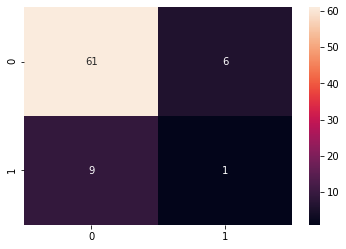

In [45]:
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [138]:
stay_df

,Unnamed: 0,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,Theatrical Engagements,Domestic Box Office,International Box Office,Worldwide Box Office,Person,Stopped making movies,Personal movie count,Personal director count,Profit
1,1,2019-12-20,Star Wars: The Rise of Skyw…,Director,Walt Disney,Adventure,275000000.0,177383864.0,4406.0,4406.0,29704.0,515202542.0,5.582671e+08,1.073470e+09,J.J. Abrams,False,26,6.0,7.984696e+08
8,8,2015-12-18,Star Wars Ep. VII: The Forc…,Director,Walt Disney,Adventure,306000000.0,247966675.0,4134.0,4134.0,37852.0,936662225.0,1.128816e+09,2.065478e+09,J.J. Abrams,False,19,5.0,1.759478e+09
13,13,2013-05-16,Star Trek Into Darkness,Director,Paramount Pictures,Adventure,190000000.0,70165559.0,3868.0,3907.0,22815.0,228778661.0,2.386029e+08,4.673816e+08,J.J. Abrams,False,14,4.0,2.773816e+08
18,18,2011-06-10,Super 8,Director,Paramount Pictures,Thriller/Suspense,50000000.0,35451168.0,3379.0,3424.0,19362.0,127004179.0,1.309686e+08,2.579727e+08,J.J. Abrams,False,9,3.0,2.079727e+08
20,20,2009-05-08,Star Trek,Director,Paramount Pictures,Adventure,140000000.0,79204289.0,3849.0,4053.0,30077.0,257730019.0,1.291096e+08,3.868396e+08,J.J. Abrams,False,7,2.0,2.468396e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,4,2002-01-18,Snow Dogs,Director,Walt Disney,Adventure,32000000.0,17814259.0,2302.0,2454.0,20301.0,81150692.0,3.574734e+07,1.168980e+08,Brian Levant,False,5,5.0,8.489803e+07
1134,5,2000-04-28,The Flintstones in Viva Roc…,Director,Universal,Adventure,58000000.0,10518435.0,3040.0,3125.0,18444.0,35231365.0,2.420000e+07,5.943136e+07,Brian Levant,False,4,4.0,1.431365e+06
1135,6,1996-11-22,Jingle All the Way,Director,20th Century Fox,Adventure,60000000.0,12112267.0,2401.0,2404.0,18205.0,60592389.0,6.924000e+07,1.298324e+08,Brian Levant,False,3,3.0,6.983239e+07
1136,7,1994-05-27,The Flintstones,Director,Universal,Comedy,45000000.0,37182745.0,2498.0,2587.0,18296.0,130531208.0,2.279688e+08,3.585000e+08,Brian Levant,False,2,2.0,3.135000e+08


In [103]:
df

,Unnamed: 0,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,Theatrical Engagements,Domestic Box Office,International Box Office,Worldwide Box Office,Person,Stopped making movies,Personal movie count,Personal director count,Profit
1,1,2019-12-20,Star Wars: The Rise of Skyw…,Director,Walt Disney,Adventure,275000000.0,177383864.0,4406.0,4406.0,29704.0,515202542.0,5.582671e+08,1.073470e+09,J.J. Abrams,False,26,6.0,7.984696e+08
8,8,2015-12-18,Star Wars Ep. VII: The Forc…,Director,Walt Disney,Adventure,306000000.0,247966675.0,4134.0,4134.0,37852.0,936662225.0,1.128816e+09,2.065478e+09,J.J. Abrams,False,19,5.0,1.759478e+09
13,13,2013-05-16,Star Trek Into Darkness,Director,Paramount Pictures,Adventure,190000000.0,70165559.0,3868.0,3907.0,22815.0,228778661.0,2.386029e+08,4.673816e+08,J.J. Abrams,False,14,4.0,2.773816e+08
18,18,2011-06-10,Super 8,Director,Paramount Pictures,Thriller/Suspense,50000000.0,35451168.0,3379.0,3424.0,19362.0,127004179.0,1.309686e+08,2.579727e+08,J.J. Abrams,False,9,3.0,2.079727e+08
20,20,2009-05-08,Star Trek,Director,Paramount Pictures,Adventure,140000000.0,79204289.0,3849.0,4053.0,30077.0,257730019.0,1.291096e+08,3.868396e+08,J.J. Abrams,False,7,2.0,2.468396e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,4,2013-11-15,The Starving Games,Director,Ketchup Entertainment,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,1.766150e+05,1.766150e+05,Aaron Seltzer,True,11,5.0,NaN
1153,10,2008-08-29,Disaster Movie,Director,Lionsgate,Comedy,20000000.0,5836973.0,2642.0,2642.0,8771.0,14190901.0,2.252985e+07,3.672075e+07,Aaron Seltzer,True,5,4.0,1.672075e+07
1154,11,2008-01-25,Meet the Spartans,Director,20th Century Fox,Comedy,30000000.0,18505530.0,2605.0,2643.0,10672.0,38233676.0,4.641316e+07,8.464683e+07,Aaron Seltzer,True,4,3.0,5.464683e+07
1155,12,2007-01-26,Epic Movie,Director,20th Century Fox,Comedy,20000000.0,18612544.0,2801.0,2840.0,11371.0,39739367.0,4.711921e+07,8.685858e+07,Aaron Seltzer,True,3,2.0,6.685858e+07


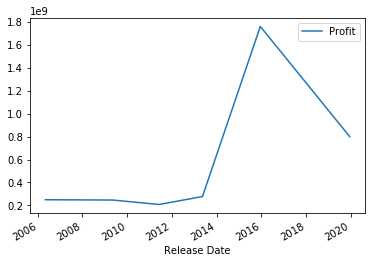

In [5]:
df.loc[df['Person'] == 'J.J. Abrams'].plot(x='Release Date', y='Profit')

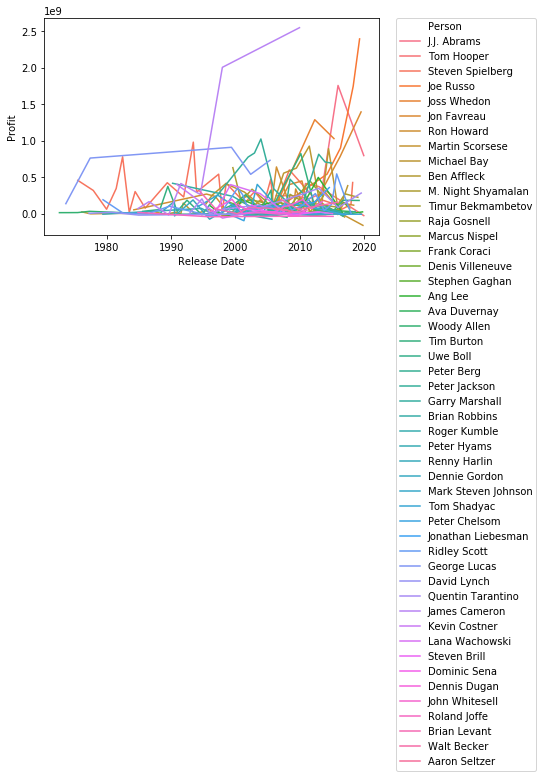

In [6]:
sns.lineplot(x='Release Date', y='Profit', hue='Person', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)